In [4]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.fft import fft
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [5]:

def compute_fft_stats(data):
    fft_data = np.abs(fft(data, axis=1))
    
    # Basic statistics
    means = [np.mean(coeff) for coeff in fft_data]
    entropies = [entropy(coeff) for coeff in fft_data]
    energy = [np.sum(coeff**2) for coeff in fft_data]
    homogeneity = [np.sum(coeff / (1 + np.abs(np.arange(len(coeff)) - np.mean(coeff)))) for coeff in fft_data]
    contrast = [np.sum((np.arange(len(coeff)) - np.mean(coeff))**2 * coeff) / np.sum(coeff) for coeff in fft_data]
    correlation = [
        (np.sum((np.arange(len(coeff)) - np.mean(coeff)) * coeff) / (len(coeff) * np.std(coeff) * np.std(np.arange(len(coeff)))))
        for coeff in fft_data
    ]
    #  Concatenate All Selected Features
    return np.concatenate((
        means, energy, entropies, homogeneity, contrast, correlation
    ))


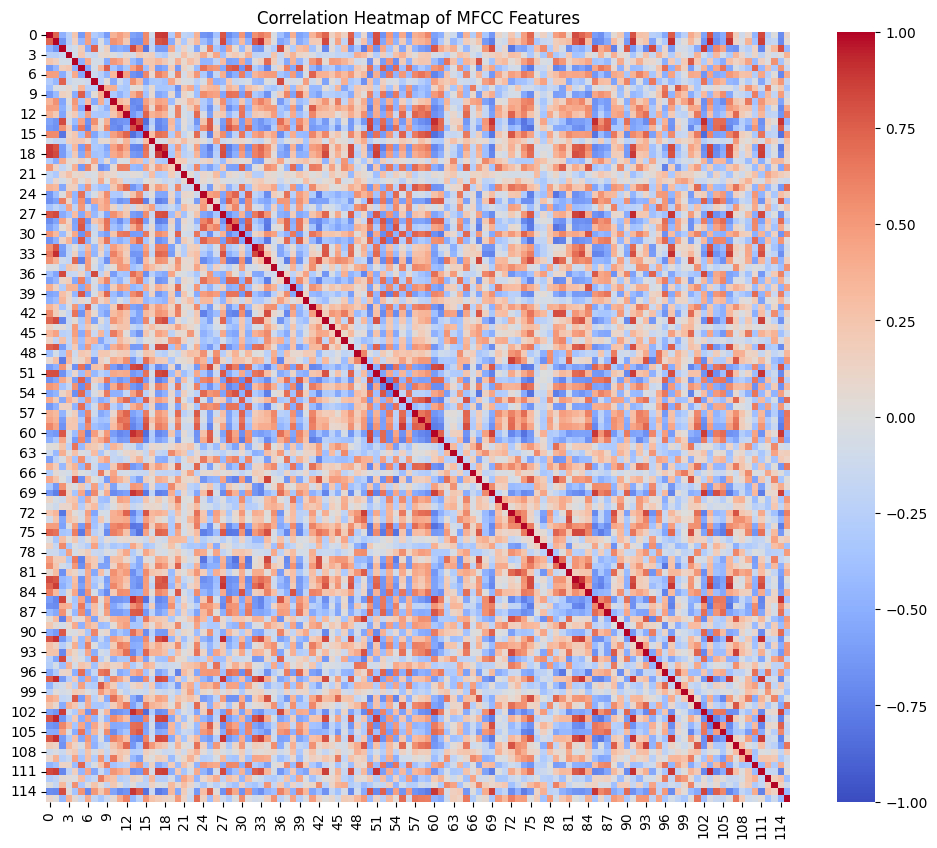

In [ ]:
data_directory_test = "TEST_MFCC"
summary_stats = []
filenames = []

for file in os.listdir(data_directory_test):
    mfcc_all = pd.read_csv(os.path.join(data_directory_test, file), header=None).values  
    mfcc = mfcc_all[:, :]
    delta_mfcc = np.diff(mfcc, axis=1, prepend=mfcc[:, [0]])
    delta_delta_mfcc = np.diff(delta_mfcc, axis=1, prepend=delta_mfcc[:, [0]])

    scaler = StandardScaler()

    standardized_mfcc = scaler.fit_transform(mfcc.T).T
    standardized_delta_mfcc = scaler.fit_transform(delta_mfcc.T).T
    standardized_delta_delta_mfcc = scaler.fit_transform(delta_delta_mfcc.T).T

    mfcc_stats = compute_fft_stats(standardized_mfcc)
    delta_mfcc_stats = compute_fft_stats(standardized_delta_mfcc)
    delta_delta_mfcc_stats = compute_fft_stats(standardized_delta_delta_mfcc)

    stats = np.concatenate((mfcc_stats, delta_mfcc_stats, delta_delta_mfcc_stats))
    summary_stats.append(stats)

    filenames.append(file)


summary_df_test = pd.DataFrame(summary_stats)

scaler = StandardScaler()
summary_df_scaled_test = scaler.fit_transform(summary_df_test)
correlation_matrix = np.corrcoef(summary_df_scaled_test)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of MFCC Features')
plt.show()




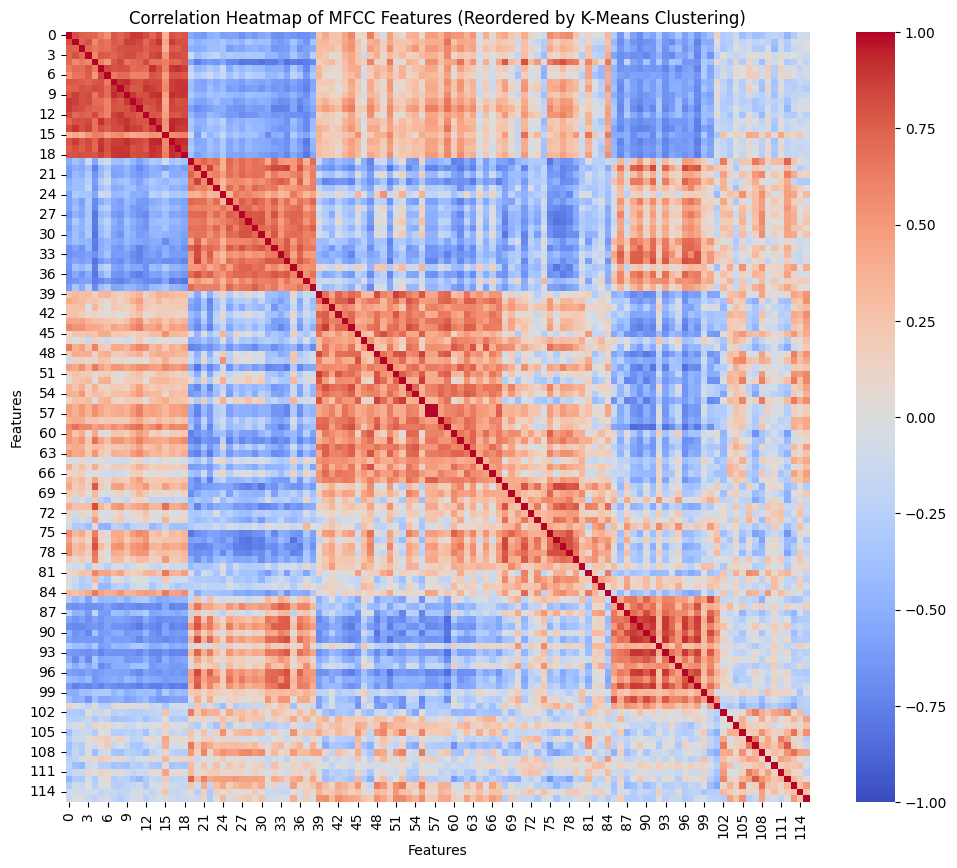

In [ ]:
correlation_matrix = np.corrcoef(summary_df_scaled_test)

n_clusters = 6 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_labels = kmeans.fit_predict(correlation_matrix)
sorted_indices = np.argsort(feature_labels)

sorted_correlation_matrix = correlation_matrix[sorted_indices, :][:, sorted_indices]

plt.figure(figsize=(12, 10))
sns.heatmap(sorted_correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of MFCC Features (Reordered by K-Means Clustering)')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()


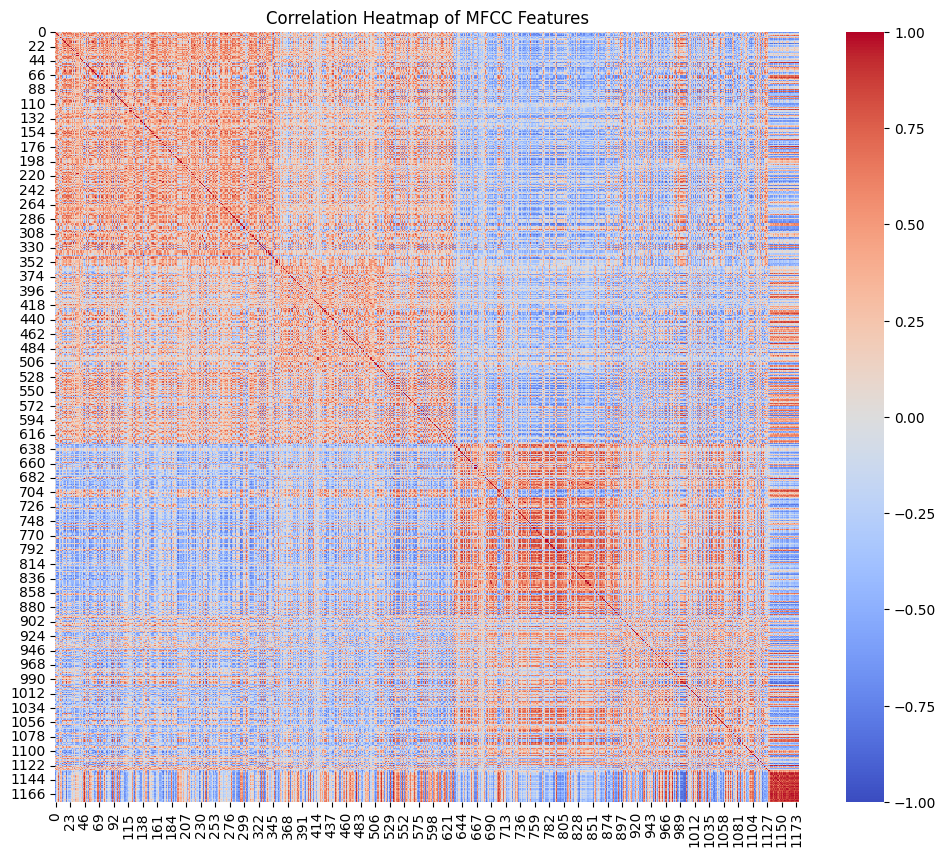

In [ ]:
data_directory_train = "TRAIN_MFCC_Final"
summary_stats = []
labels = []

for file in os.listdir(data_directory_train):
    label = file.split('-')[0]  
    labels.append(label)
    labels
    mfcc_all = pd.read_csv(os.path.join(data_directory_train, file), header=None).values  
    mfcc = mfcc_all[:, :]
    delta_mfcc = np.diff(mfcc, axis=1, prepend=mfcc[:, [0]])
    delta_delta_mfcc = np.diff(delta_mfcc, axis=1, prepend=delta_mfcc[:, [0]])

    scaler = StandardScaler()

    standardized_mfcc = scaler.fit_transform(mfcc.T).T
    standardized_delta_mfcc = scaler.fit_transform(delta_mfcc.T).T
    standardized_delta_delta_mfcc = scaler.fit_transform(delta_delta_mfcc.T).T

    mfcc_stats = compute_fft_stats(standardized_mfcc)
    delta_mfcc_stats = compute_fft_stats(standardized_delta_mfcc)
    delta_delta_mfcc_stats = compute_fft_stats(standardized_delta_delta_mfcc)

    stats = np.concatenate((mfcc_stats, delta_mfcc_stats, delta_delta_mfcc_stats))
    summary_stats.append(stats)

summary_df_train = pd.DataFrame(summary_stats)

scaler = StandardScaler()
summary_df_scaled_train = scaler.fit_transform(summary_df_train)
correlation_matrix = np.corrcoef(summary_df_scaled_train)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of MFCC Features')
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

X_1 = summary_df_scaled_test
X = summary_df_scaled_train

def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, classifier, is_smote=False):
    """Function to train and evaluate a classifier."""
    if is_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_1_pred = classifier.predict(X_1)  
    
    print(f"{classifier.__class__.__name__} (SMOTE: {is_smote}) Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    target_songs_na = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'NA']
    target_songs_ab = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'AB']
    target_songs_kk = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'KK']
    target_songs_mb = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'MB']
    target_songs_ml = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'ML']
    target_songs_mj = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 'MJ']

    return target_songs_na, target_songs_ab, target_songs_kk, target_songs_mb, target_songs_ml, target_songs_mj

y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(min_samples_split=5, bootstrap=False, max_depth=15, random_state=42)
svm_classifier = SVC(kernel='linear', C=0.2, random_state=42)

rf_target_songs_na, rf_target_songs_ab, rf_target_songs_kk, rf_target_songs_mb, rf_target_songs_ml, rf_target_songs_mj = \
    train_and_evaluate_classifier(X_train, y_train, X_test, y_test, rf_classifier, is_smote=False)

rf_smote_target_songs_na, rf_smote_target_songs_ab, rf_smote_target_songs_kk, rf_smote_target_songs_mb, rf_smote_target_songs_ml, rf_smote_target_songs_mj = \
    train_and_evaluate_classifier(X_train, y_train, X_test, y_test, rf_classifier, is_smote=True)

svm_target_songs_na, svm_target_songs_ab, svm_target_songs_kk, svm_target_songs_mb, svm_target_songs_ml, svm_target_songs_mj = \
    train_and_evaluate_classifier(X_train, y_train, X_test, y_test, svm_classifier, is_smote=False)

svm_smote_target_songs_na, svm_smote_target_songs_ab, svm_smote_target_songs_kk, svm_smote_target_songs_mb, svm_smote_target_songs_ml, svm_smote_target_songs_mj = \
    train_and_evaluate_classifier(X_train, y_train, X_test, y_test, svm_classifier, is_smote=True)

print("Random Forest Predictions (without SMOTE):")
print(f"NA: {rf_target_songs_na}")
print(f"AB: {rf_target_songs_ab}")
print(f"KK: {rf_target_songs_kk}")
print(f"MB: {rf_target_songs_mb}")
print(f"ML: {rf_target_songs_ml}")
print(f"MJ: {rf_target_songs_mj}\n")

print("Random Forest Predictions (with SMOTE):")
print(f"NA: {rf_smote_target_songs_na}")
print(f"AB: {rf_smote_target_songs_ab}")
print(f"KK: {rf_smote_target_songs_kk}")
print(f"MB: {rf_smote_target_songs_mb}")
print(f"ML: {rf_smote_target_songs_ml}")
print(f"MJ: {rf_smote_target_songs_mj}\n")

print("SVM Predictions (without SMOTE):")
print(f"NA: {svm_target_songs_na}")
print(f"AB: {svm_target_songs_ab}")
print(f"KK: {svm_target_songs_kk}")
print(f"MB: {svm_target_songs_mb}")
print(f"ML: {svm_target_songs_ml}")
print(f"MJ: {svm_target_songs_mj}\n")

print("SVM Predictions (with SMOTE):")
print(f"NA: {svm_smote_target_songs_na}")
print(f"AB: {svm_smote_target_songs_ab}")
print(f"KK: {svm_smote_target_songs_kk}")
print(f"MB: {svm_smote_target_songs_mb}")
print(f"ML: {svm_smote_target_songs_ml}")
print(f"MJ: {svm_smote_target_songs_mj}")


RandomForestClassifier (SMOTE: False) Metrics:
Accuracy: 0.8050847457627118
Classification Report:
              precision    recall  f1-score   support

          AB       0.80      0.89      0.84       111
          KK       0.67      0.82      0.74        51
          MB       0.54      0.34      0.42        38
          MJ       0.99      0.86      0.92        80
          ML       0.84      0.83      0.83        64
          NA       0.90      0.90      0.90        10

    accuracy                           0.81       354
   macro avg       0.79      0.77      0.78       354
weighted avg       0.80      0.81      0.80       354

Confusion Matrix:
[[99  5  4  0  3  0]
 [ 5 42  3  0  0  1]
 [12 10 13  0  3  0]
 [ 2  4  1 69  4  0]
 [ 6  1  3  1 53  0]
 [ 0  1  0  0  0  9]]

RandomForestClassifier (SMOTE: True) Metrics:
Accuracy: 0.8107344632768362
Classification Report:
              precision    recall  f1-score   support

          AB       0.83      0.85      0.84       111
     

In [ ]:
X_1 = summary_df_scaled_test
target_labels = ['NA','AB', 'KK', 'MJ']
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, classifier, is_smote=False):
    """Function to train and evaluate a classifier"""
    if is_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_1_pred = classifier.predict(X_1)
    
    print(f"{classifier.__class__.__name__} (SMOTE: {is_smote}) Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")


    target_songs = [filenames[i] for i, pred in enumerate(y_1_pred) if pred == 1]
    
    return target_songs


for target in target_labels:
    binary_labels = [1 if label == target else 0 for label in labels]
    y = np.array(binary_labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    rf_classifier = RandomForestClassifier(min_samples_split=5, bootstrap=False, max_depth=15, random_state=42)
    svm_classifier = SVC(kernel='linear', C=0.2, random_state=42)

    target_songs_rf = train_and_evaluate_classifier(X_train, y_train, X_test, y_test, rf_classifier, is_smote=False)
    target_songs_svm = train_and_evaluate_classifier(X_train, y_train, X_test, y_test, svm_classifier, is_smote=False)

    target_songs_rf_smote = train_and_evaluate_classifier(X_train, y_train, X_test, y_test, rf_classifier, is_smote=True)
    target_songs_svm_smote = train_and_evaluate_classifier(X_train, y_train, X_test, y_test, svm_classifier, is_smote=True)
    rf_prediction = set(target_songs_rf)
    svm_prediction = set(target_songs_svm)
    rf_smote_prediction = set(target_songs_rf_smote)
    svm_smote_prediction = set(target_songs_svm_smote)

    common_predictions = rf_prediction & svm_prediction & rf_smote_prediction & svm_smote_prediction
    print(f"Songs that belong to the target '{target}' (RF without SMOTE): {target_songs_rf}")
    print(f"Songs that belong to the target '{target}' (SVM without SMOTE): {target_songs_svm}")
    print(f"Songs that belong to the target '{target}' (RF with SMOTE): {target_songs_rf_smote}")
    print(f"Songs that belong to the target '{target}' (SVM with SMOTE): {target_songs_svm_smote}")
    print(f"Common predictions by all models : {common_predictions}")


RandomForestClassifier (SMOTE: False) Metrics:
Accuracy: 0.9915254237288136
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       344
           1       0.89      0.80      0.84        10

    accuracy                           0.99       354
   macro avg       0.94      0.90      0.92       354
weighted avg       0.99      0.99      0.99       354

Confusion Matrix:
[[343   1]
 [  2   8]]

SVC (SMOTE: False) Metrics:
Accuracy: 0.9971751412429378
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       344
           1       1.00      0.90      0.95        10

    accuracy                           1.00       354
   macro avg       1.00      0.95      0.97       354
weighted avg       1.00      1.00      1.00       354

Confusion Matrix:
[[344   0]
 [  1   9]]

RandomForestClassifier (SMOTE: True) Metrics:
Accuracy: 0.9915254237288136
Classifi